In [1]:
import tensorflow as tf
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [2]:
data_dir = pathlib.Path('./Image_Data')
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

33000

The languages specified in the if statement are the ones on which the model will be trained. These languages should have already been extracted using the Data_Explorer notbook.

In [3]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if (item.name == "Turkish" or item.name == "Dutch" or item.name == "Swedish" or item.name == "Persian" or item.name == "Mongolian")])
CLASS_NAMES
list(CLASS_NAMES)

['Turkish', 'Dutch', 'Swedish', 'Mongolian', 'Persian']

Getting the image generator using a rescale factor of 1/255, to get the pixel values from a range of [0,255] to a range of [0,1] as Deep learning models behave better with inputs values between 0 and 1.

In [4]:
# The 1./255 is to convert from uint8 to float32 in range [0,1].
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)

Defined the batch size for both training and testing image generators.

In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 200
IMG_WIDTH = 200
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [6]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

test_data_gen = image_generator.flow_from_directory(directory='./Image_Data_Test',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 15000 images belonging to 5 classes.
Found 1875 images belonging to 5 classes.


This function is used to show a batch of data for easy visualization of the data.

In [7]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

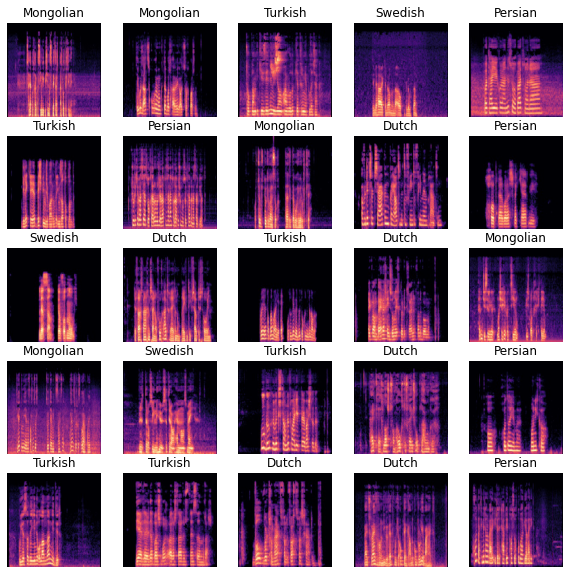

In [8]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
import pickle
from keras.models import model_from_json
from keras.models import load_model

Using TensorFlow backend.


In [10]:
from tensorflow.keras.regularizers import l2

weight_decay = 0.001

# Construct model 
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, kernel_regularizer=l2(weight_decay), input_shape=(200,200,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.20))

model.add(Conv2D(filters=64, kernel_size=2, kernel_regularizer=l2(weight_decay), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.20))

model.add(Conv2D(filters=128, kernel_size=2, kernel_regularizer=l2(weight_decay), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.50))

model.add(Conv2D(filters=256, kernel_size=2, kernel_regularizer=l2(weight_decay), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Conv2D(filters=512, kernel_size=2, kernel_regularizer=l2(weight_decay), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(1024, kernel_regularizer=l2(weight_decay)))
model.add(Activation("relu"))

model.add(Dense(len(CLASS_NAMES), activation='softmax'))

Many optimizers were tested but adam gave the best results.

In [11]:
# Compiling the model using some basic parameters
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

In [12]:
# history = model.fit(train_data_gen, epochs=25)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)
# history = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, callbacks=[callback])
history = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 469 steps, validate for 59 steps
Epoch 1/50
469/469 [==============================] - 335s 715ms/step - loss: 4.2505 - accuracy: 0.4419 - val_loss: 7.6805 - val_accuracy: 0.2000
Epoch 2/50
469/469 [==============================] - 64s 136ms/step - loss: 2.2074 - accuracy: 0.5672 - val_loss: 2.2593 - val_accuracy: 0.4384
Epoch 3/50
469/469 [==============================] - 64s 136ms/step - loss: 1.5790 - accuracy: 0.6584 - val_loss: 1.7938 - val_accuracy: 0.5931
Epoch 5/50
469/469 [==============================] - 63s 135ms/step - loss: 1.6058 - accuracy: 0.6824 - val_loss: 1.9052 - val_accuracy: 0.6091
Epoch 6/50
469/469 [==============================] - 64s 136ms/step - loss: 1.6768 - accuracy: 0.6987 - val_loss: 1.6644 - val_accuracy: 0.6608
Epoch 7/50
469/469 [==============================] - 64s 136ms/step - loss: 1.5291 - accuracy: 0.7201 - val_loss: 1.5719 - val_accuracy: 0.7083
Epoch 8/50
469/469 [================

In [13]:
# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

model.save('CNN.model')

Saved model to disk
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: CNN.model/assets


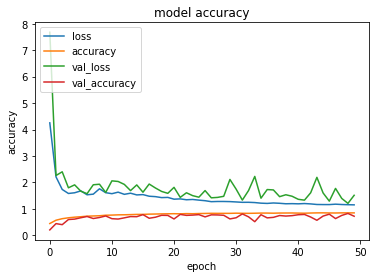

In [14]:
# Printing a graph showing the accuracy changes during the training phase
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy', 'val_loss', 'val_accuracy'], loc='upper left')

As we can see from the training process in the cell a few cells above that the best validation accuracy was 83%, to capture that we will just have to add a Keras callback to save the best model i.e. having the best validation accuracy. So we can conclude that we can achieve around 83% accuracy using this method and the current hyper-parameters.

In [15]:
loss, acc = model.evaluate(test_data_gen)  # returns loss and metrics
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

  ...
    to  
  ['...']
59/59 [==============================] - 4s 70ms/step - loss: 1.5102 - accuracy: 0.7179
loss: 1.51
acc: 0.72
